# CAPM in Python: Estimating Tesla's Beta (Local Data)

This notebook demonstrates a **simple, practical** CAPM beta estimation using **only local data files**.

## Goal
Estimate Tesla's beta by running a linear regression on **daily excess returns**:

$$
R_{i,t} - R_{f,t} = \alpha + \beta\,(R_{m,t} - R_{f,t}) + \varepsilon_t
$$

Shorthand (same idea):

$$
(R_i - R_f) = a + b\,(R_m - R_f)
$$

where $a$ corresponds to $\alpha$ and $b$ corresponds to $\beta$.

where:
- $R_{i,t}$: Tesla daily return
- $R_{m,t}$: S&P 500 daily return
- $R_{f,t}$: risk-free daily return (from 1-year US Treasury yield)


## Data requirements (local)

All inputs are read from `materials/data/` (or `data/` if you run the notebook from inside `materials/`).

- Tesla daily prices: `tesla_daily_price.xlsx`
- S&P 500 index level: `sp500_index_fred.csv`
- 1-year US Treasury yield: `us_1y_treasury_yield_dgs1.csv`

Return construction:
- Daily return: $(P_t / P_{t-1}) - 1$
- Risk-free yield is annualized; we convert it to a **daily** risk-free return using a 252-trading-day convention.


In [1]:
# Optional: (re)download the local datasets
#
# Why optional?
# - This notebook is designed to run purely from local files.
# - Some sources (e.g., Yahoo via yfinance) may be rate-limited.
#
# This cell uses:
# - TSLA prices: Stooq
# - S&P 500 index level: FRED (SP500)
# - 1Y Treasury yield: FRED (DGS1)
#
# Set REDOWNLOAD=True if you want to refresh/extend the files in DATA_DIR.
REDOWNLOAD = False
START_DATE = '2021-01-01'
END_DATE = '2025-12-31'

if not REDOWNLOAD:
    print('Skipping download. Set REDOWNLOAD=True to (re)download local data files.')
else:
    from pathlib import Path
    import pandas as pd

    DATA_DIR = Path('data') if Path('data').exists() else Path('materials/data')
    DATA_DIR.mkdir(parents=True, exist_ok=True)

    start = pd.Timestamp(START_DATE)
    end = pd.Timestamp(END_DATE)

    # --- TSLA (Stooq) ---
    url_tsla = 'https://stooq.com/q/d/l/?s=tsla.us&i=d'
    tsla = pd.read_csv(url_tsla)
    tsla['Date'] = pd.to_datetime(tsla['Date'])
    tsla = tsla[(tsla['Date'] >= start) & (tsla['Date'] <= end)].copy()
    if tsla.empty:
        raise RuntimeError('TSLA download returned empty after filtering. Not overwriting local file.')
    tsla = tsla.set_index('Date').sort_index()
    tsla['Dividends'] = 0.0
    tsla['Stock Splits'] = 0.0
    tsla = tsla[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']]
    tsla_out = DATA_DIR / 'tesla_daily_price.xlsx'
    tsla.to_excel(tsla_out)

    # --- S&P 500 (FRED: SP500) ---
    sp_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=SP500'
    sp = pd.read_csv(sp_url)
    sp = sp.rename(columns={'observation_date': 'Date'})
    sp['Date'] = pd.to_datetime(sp['Date'])
    sp['SP500'] = pd.to_numeric(sp['SP500'], errors='coerce')
    sp = sp[(sp['Date'] >= start) & (sp['Date'] <= end)].copy()
    if sp.empty:
        raise RuntimeError('SP500 download returned empty after filtering. Not overwriting local file.')
    sp_out = DATA_DIR / 'sp500_index_fred.csv'
    sp[['Date', 'SP500']].to_csv(sp_out, index=False)

    # --- Risk-free (FRED: DGS1) ---
    rf_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=DGS1'
    rf = pd.read_csv(rf_url)
    rf = rf.rename(columns={'observation_date': 'Date'})
    rf['Date'] = pd.to_datetime(rf['Date'])
    rf['DGS1'] = pd.to_numeric(rf['DGS1'], errors='coerce')
    rf = rf[(rf['Date'] >= start) & (rf['Date'] <= end)].copy()
    if rf.empty:
        raise RuntimeError('DGS1 download returned empty after filtering. Not overwriting local file.')
    rf_out = DATA_DIR / 'us_1y_treasury_yield_dgs1.csv'
    rf[['Date', 'DGS1']].to_csv(rf_out, index=False)

    print('Wrote:')
    print('-', tsla_out.resolve())
    print('-', sp_out.resolve())
    print('-', rf_out.resolve())
    print('Re-run the next cells to reload the updated local files.')


Skipping download. Set REDOWNLOAD=True to (re)download local data files.


In [2]:
# Setup: imports + local paths
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')

# Make paths robust whether Jupyter is launched from repo root or from `materials/`.
DATA_DIR = Path('data') if Path('data').exists() else Path('materials/data')

TSLA_PATH = DATA_DIR / 'tesla_daily_price.xlsx'
SP500_PATH = DATA_DIR / 'sp500_index_fred.csv'
RF_PATH = DATA_DIR / 'us_1y_treasury_yield_dgs1.csv'

for p in [TSLA_PATH, SP500_PATH, RF_PATH]:
    if not p.exists():
        raise FileNotFoundError(
            f"Missing local file: {p.resolve()}\n"
            "Place the required datasets under materials/data/ before running."
        )

TSLA_PATH, SP500_PATH, RF_PATH


(WindowsPath('data/tesla_daily_price.xlsx'),
 WindowsPath('data/sp500_index_fred.csv'),
 WindowsPath('data/us_1y_treasury_yield_dgs1.csv'))

In [3]:
# Load datasets
tsla = pd.read_excel(TSLA_PATH, index_col=0)
tsla.index = pd.to_datetime(tsla.index)
tsla = tsla.sort_index()

sp500 = pd.read_csv(SP500_PATH)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date').sort_index()

rf = pd.read_csv(RF_PATH)
rf['Date'] = pd.to_datetime(rf['Date'])
rf = rf.set_index('Date').sort_index()

print('TSLA range:', tsla.index.min().date(), 'to', tsla.index.max().date(), 'rows', len(tsla))
print('SP500 range:', sp500.index.min().date(), 'to', sp500.index.max().date(), 'rows', len(sp500))
print('DGS1 range:', rf.index.min().date(), 'to', rf.index.max().date(), 'rows', len(rf))

tsla[['Close']].head()


TSLA range: 2021-01-04 to 2025-12-31 rows 1255
SP500 range: 2021-01-01 to 2025-12-31 rows 1304
DGS1 range: 2021-01-01 to 2025-12-31 rows 1304


,Close
Date,
2021-01-04,243.257
2021-01-05,245.037
2021-01-06,251.993
2021-01-07,272.013
2021-01-08,293.340


## Step 1 — Build daily returns

We compute daily simple returns:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

For the risk-free rate, the 1-year Treasury series is an **annualized yield** (percent per year).
We convert it to a daily return using:

$$
R_{f,\,daily} = (1+R_{f,\,annual})^{1/252} - 1
$$


In [4]:
# Daily returns: Tesla and S&P 500
Ri = tsla['Close'].pct_change().rename('Ri')
# FRED series can include NaNs on non-trading days; drop them before computing returns.
Rm = sp500['SP500'].dropna().pct_change().rename('Rm')

# Align Tesla and market returns first (trading days)
ret = pd.concat([Ri, Rm], axis=1).dropna()

# Risk-free: DGS1 is an annual yield in percent (e.g., 5.2 means 5.2% per year)
rf_annual = (rf['DGS1'] / 100.0).rename('Rf_annual').ffill()
rf_annual = rf_annual.reindex(ret.index).ffill()

# Convert annual yield to daily return (252 trading days convention)
Rf_daily = ((1 + rf_annual) ** (1 / 252) - 1).rename('Rf_daily')

df = ret.join(Rf_daily).dropna()
df['Excess_i'] = df['Ri'] - df['Rf_daily']
df['Excess_m'] = df['Rm'] - df['Rf_daily']

df.head()


,Ri,Rm,Rf_daily,Excess_i,Excess_m
Date,,,,,
2021-01-05,0.007317,0.007083,0.000004,0.007313,0.007079
2021-01-06,0.028388,0.005710,0.000004,0.028383,0.005706
2021-01-07,0.079447,0.014847,0.000004,0.079442,0.014843
2021-01-08,0.078404,0.005492,0.000004,0.078400,0.005488
2021-01-11,-0.078213,-0.006555,0.000004,-0.078217,-0.006559


In [5]:
# (Optional) Annualize average returns for interpretation (not needed for beta estimation)
def annualize_return_geom(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    r = daily_returns.dropna().to_numpy()
    if r.size == 0:
        return float('nan')
    return float((np.prod(1 + r) ** (periods_per_year / r.size)) - 1)

def annualize_vol(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    return float(daily_returns.dropna().std() * np.sqrt(periods_per_year))

summary = pd.DataFrame(
    {
        'Ann. return (geom)': [
            annualize_return_geom(df['Ri']),
            annualize_return_geom(df['Rm']),
            annualize_return_geom(df['Rf_daily']),
        ],
        'Ann. vol': [
            annualize_vol(df['Ri']),
            annualize_vol(df['Rm']),
            annualize_vol(df['Rf_daily']),
        ],
    },
    index=['TSLA', 'S&P 500', 'Risk-free (proxy)'],
)
summary


,Ann. return (geom),Ann. vol
TSLA,0.131438,0.607358
S&P 500,0.131569,0.169574
Risk-free (proxy),0.032999,0.001172


## Step 2 — CAPM regression (beta estimation)

We estimate beta using OLS:

$$
R_{i,t} - R_{f,t} = \alpha + \beta\,(R_{m,t} - R_{f,t}) + \varepsilon_t
$$

Shorthand:

$$
(R_i - R_f) = a + b\,(R_m - R_f)
$$

- The slope $b$ (i.e., $\beta$) is the **beta estimate**.
- The intercept $a$ (i.e., $\alpha$) is often interpreted as **abnormal return** (should be ~0 in a strict CAPM world).


In [6]:
# Run OLS regression
X = sm.add_constant(df['Excess_m'])
y = df['Excess_i']

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Excess_i   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     612.2
Date:                Wed, 11 Feb 2026   Prob (F-statistic):          2.32e-110
Time:                        11:16:09   Log-Likelihood:                 2563.0
No. Observations:                1254   AIC:                            -5122.
Df Residuals:                    1252   BIC:                            -5112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.258      0.797      -0.002       0.002
Excess_m       2.0526      0.083     24.743      0.000       1.890       2.215
==============================================================================
Omnibus:                      146.495   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.477
Skew:                           0.343   Prob(JB):                    1.17e-193
Kurtosis:                       7.066   Cond. No.                         93.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# Extract alpha and beta
alpha = float(model.params['const'])
beta = float(model.params['Excess_m'])
r2 = float(model.rsquared)

{'alpha (daily)': alpha, 'beta': beta, 'R^2': r2}


{'alpha (daily)': 0.00022836483500909344,
 'beta': 2.0525972501715524,
 'R^2': 0.328401509507536}

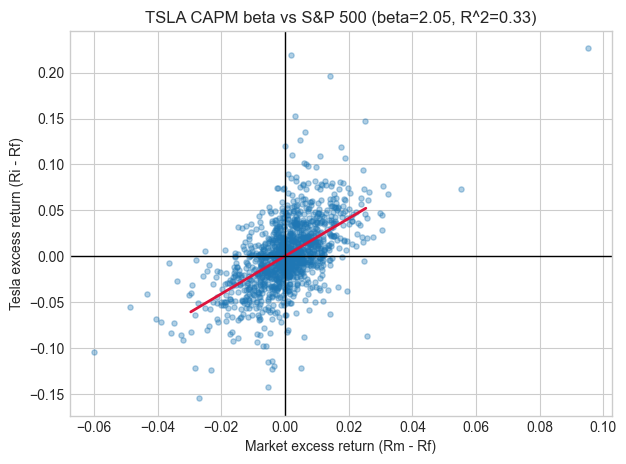

In [8]:
# Visualize: scatter + fitted line
x = df['Excess_m']
y = df['Excess_i']

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.35, s=14)

x_line = np.linspace(x.quantile(0.01), x.quantile(0.99), 200)
y_line = alpha + beta * x_line
plt.plot(x_line, y_line, color='crimson', linewidth=2)

plt.title(f"TSLA CAPM beta vs S&P 500 (beta={beta:.2f}, R^2={r2:.2f})")
plt.xlabel('Market excess return (Rm - Rf)')
plt.ylabel('Tesla excess return (Ri - Rf)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()


## Quick interpretation

- If $\beta > 1$, Tesla tends to move **more** than the market (higher systematic risk).
- If $\beta < 1$, Tesla tends to move **less** than the market.
- Beta is **dimensionless**; it summarizes sensitivity of the stock to market movements.

In valuation, beta is commonly used to compute the **cost of equity** via CAPM:

$$
R_e = R_f + \beta\,(E[R_m] - R_f)
$$
